In [1]:
import json
import os
from madmom.audio.chroma import DeepChromaProcessor
from featureExtraction import chromagram
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


wavfolder = "generated_chords/wav"

processor = DeepChromaProcessor()


deepchromas = list()
chromas = list()

instruments = list()
chords = list()
octaves = list()
inversions = list()
img_paths = list()

for audio in tqdm(os.listdir(wavfolder)):
    if audio.endswith(".wav"):
        
        path = os.path.join(wavfolder, audio)
        
        chroma = processor(path)
        deepchromas.append(chroma)

        img_path = os.path.join("imgs", audio.replace(".wav", ".png"))
        if not os.path.exists(img_path) and 0:
            plt.imshow(chroma, origin='lower', aspect='auto', resample=True)
            plt.savefig(img_path, bbox_inches='tight')
        img_paths += [img_path] * chroma.shape[0]

        try:
            instrument, chord, octave, inversion = re.findall(r"(.*)_(.*_.*)_(\d)_(\d).wav", audio)[0]
            instruments += [instrument] * chroma.shape[0]
            chords += [chord] * chroma.shape[0]
            octaves += [octave] * chroma.shape[0]
            inversions += [inversion] * chroma.shape[0]
        except:
            pass

X = np.vstack(deepchromas)

100%|██████████| 5040/5040 [00:49<00:00, 101.71it/s]


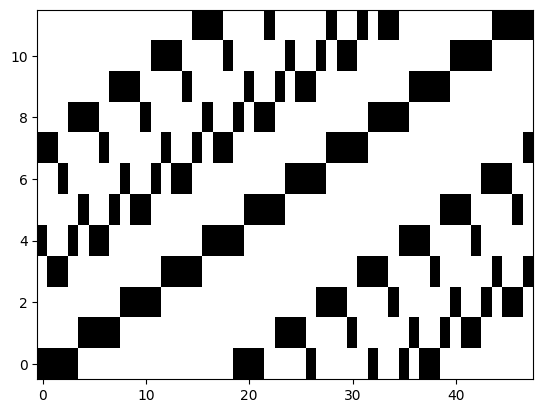

In [2]:
%load_ext autoreload
%autoreload 2
from dataProcessing import build_chord_templates
chord_templates = build_chord_templates()
templates = np.array(list(chord_templates.values()))
plt.imshow(templates.T, origin='lower', aspect='auto', cmap='gray_r')
plt.title("Chord templates")
plt.xlabel("Chroma")
plt.ylabel("Template")
template_labels = list(chord_templates.keys())

### Baseline: Random Forest

In [4]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

RF = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)

# Evaluate the model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(RF, X, chords, cv=cv, scoring='accuracy')
print(f"Mean accuracy: {np.mean(scores):.3f}")

Mean accuracy: 0.684


### Assess the optimal number of clusters based on coherence

In [5]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score
from sklearn.mixture import GaussianMixture

from tqdm import trange
rands = list()
mis = list()
fmis = list()
sil = list()
bics = list()
aics = list()


100%|██████████| 33/33 [14:53<00:00, 27.07s/it]


In [6]:

for n in trange(36, 60):
    #kmeans = KMeans(n_clusters=n, random_state=123)
    gmm = GaussianMixture(n_components=n, covariance_type='full', init_params='kmeans', max_iter=1000, random_state=42)
    gmm.fit(X)

    # Compute AIC and BIC
    bic = gmm.bic(X)
    aic = gmm.aic(X)
    bics.append(bic)
    aics.append(aic)
    clusters = gmm.fit_predict(X)
    rands.append(adjusted_rand_score(chords, clusters))
    mis.append(normalized_mutual_info_score(chords, clusters))
    fmis.append(fowlkes_mallows_score(chords, clusters))
    #sil.append(silhouette_score(X, clusters))

 12%|█▎        | 3/24 [03:20<23:26, 66.97s/it]


KeyboardInterrupt: 

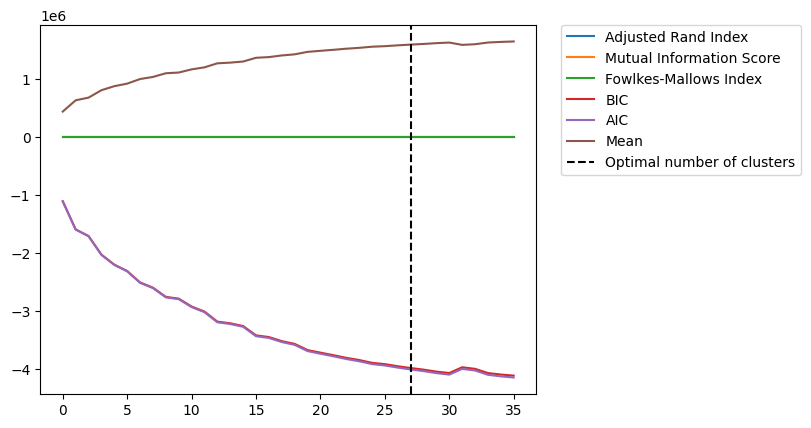

In [7]:

plt.plot(rands, label="Adjusted Rand Index")
plt.plot(mis, label="Mutual Information Score")
plt.plot(fmis, label="Fowlkes-Mallows Index")
plt.plot(bics, label="BIC")
plt.plot(aics, label="AIC")
# Mean of all metrics
plt.plot(np.mean([rands, mis, fmis, 1-np.array(aics), 1-np.array(bics)], axis=0), label="Mean")

# Add vline for optimal number of clusters
optim_n = np.argmax(np.mean([rands, mis, fmis], axis=0))
plt.axvline(optim_n, color='black', linestyle='--', label="Optimal number of clusters")

#plt.plot(sil, label="Silhouette Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Fit the GMM with the optimal number of classes

In [8]:
gmm = GaussianMixture(n_components=optim_n, covariance_type='full', init_params="kmeans", max_iter=1000, random_state=42)
clusters = gmm.fit_predict(X)

### Plot the clustering

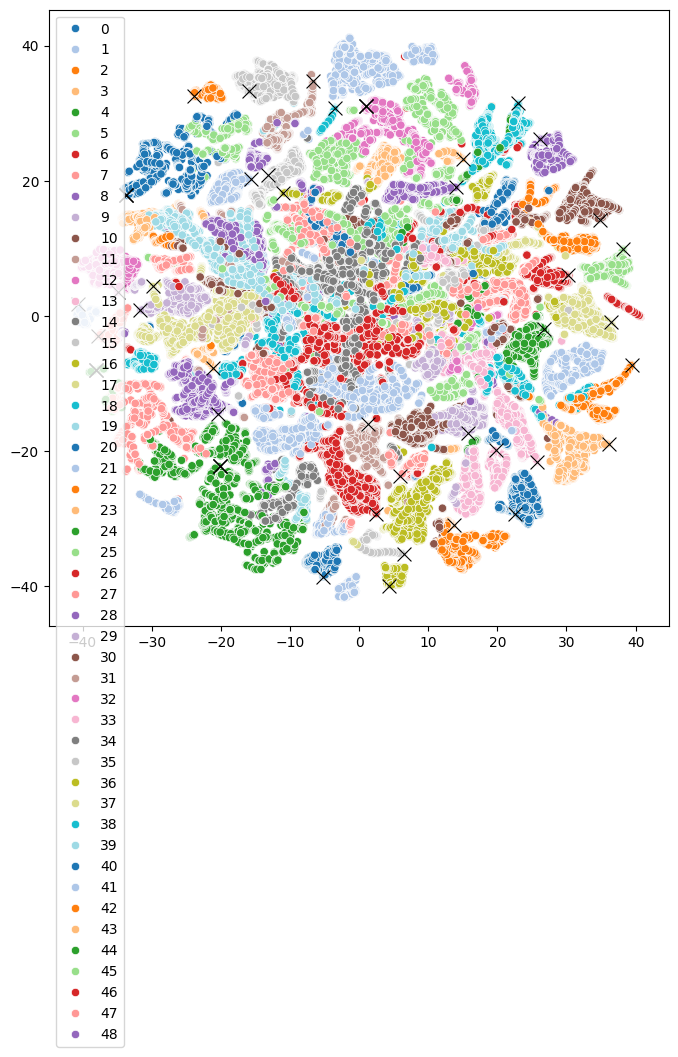

In [10]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns

def plot_clusters(coords, template_coords, clusters):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette='tab20')
    #sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette='tab20')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.scatterplot(x=template_coords[:, 0], y=template_coords[:, 1], color='black', s=100, marker='x')
    plt.show()

# Plot the cluster assignments
tsne = TSNE(n_jobs=-1)
coords = tsne.fit_transform(np.vstack([X, templates]))
sample_coords = coords[:-len(templates)]
template_coords = coords[-len(templates):]

plot_clusters(sample_coords, template_coords, clusters)

### Assess the content of each cluster

In [11]:
import pandas as pd
# Count the proportion of each chord in each cluster
cluster_df = pd.DataFrame({'cluster': clusters, 'chord': chords})
cluster_df = cluster_df.groupby(['cluster'])["chord"].value_counts().reset_index()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cluster_df)

     cluster          chord  count
0          0    D_Augmented    672
1          0   F#_Augmented    514
2          0   Bb_Augmented    373
3          1   Bb_Augmented    254
4          1       Bb_Major    234
5          1    B_Augmented    232
6          1        B_Minor    226
7          1  Bb_Diminished    223
8          1        B_Major    220
9          1       Bb_Minor    220
10         1   B_Diminished    215
11         1        A_Major    204
12         1    A_Augmented    198
13         1        A_Minor    198
14         1   Ab_Augmented    187
15         1   A_Diminished    168
16         1   F#_Augmented    157
17         1       Ab_Major    156
18         1   G_Diminished    140
19         1        G_Minor    139
20         1  Ab_Diminished    135
21         1    G_Augmented    135
22         1       F#_Major    131
23         1  F#_Diminished    120
24         1        G_Major    119
25         1       Ab_Minor    118
26         1       F#_Minor    118
27         1    F_Au

### Create cluster labels

In [12]:
from sklearn.cluster import KMeans

template_clusters = gmm.predict(templates)

cluster_mapping = dict()
for cluster, label in zip(template_clusters, template_labels):
    cluster_mapping[cluster] = label

In [13]:
len(np.unique(template_clusters))

# Find repeated template_clusters
from collections import Counter
c = Counter(template_clusters)
repeated_clusters = [cluster for cluster, count in c.items() if count > 1]
repeated_clusters

[32, 4, 28, 0, 15, 44, 18]

In [14]:
for c, l in zip(template_clusters, template_labels):
    print(c, l)

13 C_Major
43 C_Minor
22 C_Diminished
32 C_Augmented
41 C#_Major
16 C#_Minor
12 C#_Diminished
4 C#_Augmented
42 D_Major
6 D_Minor
28 D_Diminished
0 D_Augmented
2 Eb_Major
29 Eb_Minor
15 Eb_Diminished
44 Eb_Augmented
23 E_Major
9 E_Minor
24 E_Diminished
32 E_Augmented
21 F_Major
31 F_Minor
11 F_Diminished
4 F_Augmented
8 F#_Major
37 F#_Minor
10 F#_Diminished
0 F#_Augmented
47 G_Major
18 G_Minor
25 G_Diminished
44 G_Augmented
3 Ab_Major
17 Ab_Minor
35 Ab_Diminished
32 Ab_Augmented
36 A_Major
33 A_Minor
48 A_Diminished
4 A_Augmented
18 Bb_Major
28 Bb_Minor
40 Bb_Diminished
0 Bb_Augmented
15 B_Major
20 B_Minor
26 B_Diminished
44 B_Augmented


### Compute the "accuracy" of the clustering

In [15]:
gmm_y = list(map(lambda x: cluster_mapping.get(x, "None"), clusters))

from sklearn.metrics import accuracy_score
print(accuracy_score(chords, gmm_y))

0.40654761904761905


### Try it with a sequence of chords

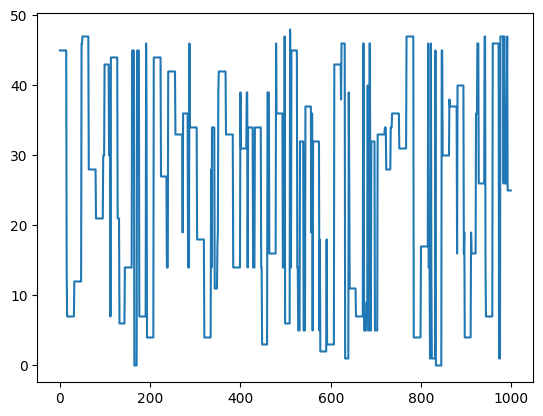

In [16]:
predictions = gmm.predict(X[:1000])
plt.plot(predictions)

In [193]:
gmm_y

['D#_Major',
 'D#_Major',
 'D#_Major',
 'D#_Major',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'D#_Major',
 'D#_Major',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'G_Minor',
 'B_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'A#_Major',
 'B_Major',
 'D#_Major',
 'D#_Major',
 'None',
 'None',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'D_Minor',
 'None',
 'None',
 'None',
 'B_Major',
 'E_Minor',
 'E_Minor',
 'E_Minor',
 'E_Minor',
 'E_Minor',
 'E_Minor',
 'E_Minor',
 'C#_Minor',
 'B_Major',
 'B_Major',
 'D#_Major',
 'D#_Major',
 'D#_Major',
 'D#_Major',
 'D#_Major',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'No

### Interactive TSNE

In [18]:
from faerun import Faerun
f = Faerun(clear_color="#111111", view="front", coords=False)

instruments = np.array(instruments).flatten()
img_paths = np.array(img_paths).flatten()
cat_chords, chord_data = Faerun.create_categories(chords)
cat_clusters, cluster_data = Faerun.create_categories(gmm_y)
cat_instruments, instruments_data = Faerun.create_categories(instruments)

misclassified = (np.array(chords) == np.array(gmm_y)).astype(str)
cat_misclassified, misclassified = Faerun.create_categories(misclassified)

labels = list()

for i in range(len(chord_data)):
    labels.append(f'{chords[i]}_{cluster_data[i]}__{instruments_data[i]}__<img src="{img_paths[i]}" width=500px>')

f.add_scatter(
    "embeddings",
    {
        "x": coords[:, 0], 
        "y": coords[:, 1], 
        "c": [chord_data, cluster_data, instruments_data, misclassified],
        "labels": labels,
    },
    colormap=["tab20", "tab20", "tab20"],
    shader="smoothCircle",
    point_scale=2,
    max_point_size=8,
    has_legend=[True, True, True, True],
    legend_labels=[cat_chords, cat_clusters, cat_instruments, cat_misclassified],
    categorical=[True, True, True, True],
    series_title=["True class", "Cluster", "Instruments", "Correctly classified"],
    selected_labels=["Cluster", "Instruments"],
    label_index=0,
    title_index=0
)

f.plot("TSNE_GMM", template="default")

/home/angel/SMC/mir/chordclustering/TSNE_GMM.html

In [187]:
cat_instruments

[(0, 'Bassoon'),
 (1, 'Clarinet'),
 (2, 'Contrabass'),
 (3, 'Flute'),
 (4, 'Guitar'),
 (5, 'Harp'),
 (6, 'Oboe'),
 (7, 'Piano'),
 (8, 'Piccolo'),
 (9, 'Saxophone'),
 (10, 'Trombone'),
 (11, 'Trumpet'),
 (12, 'Viola'),
 (13, 'Violin'),
 (14, 'Violoncello')]

# TODO

* Asignar a cada cluster su etiqueta según el template más cercano
* Analizar los que están mal clasificados
* Hacerlo solo con clarinete
* Hacerlo con todos los audios de music21
* Plottear el chord tracking para una secuencia de acordes
* Aplicar HMM/viterbi decoding (opcional)
* A ver si mejora poniendo un cluster más (para cuando no suena nada)

Most likely hidden state sequence: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 18 18 18  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 21  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7 15 15 20 20  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5 18  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4 22]


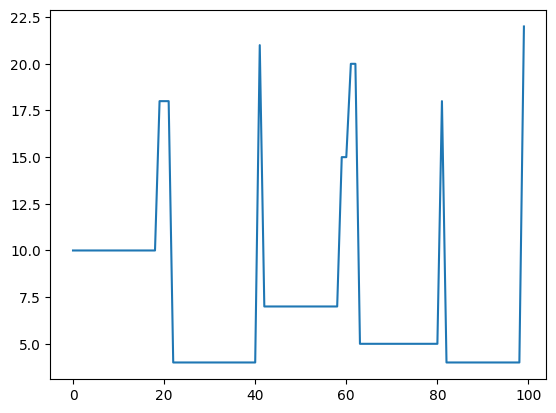

In [128]:
import numpy as np
from hmmlearn import hmm

n_states = 25  # Number of hidden states
n_observations = 25  # Number of observed classes

# Transition probability matrix (random uniform example)
transition_probs = np.full((n_states, n_states), 1/n_states)

# Emission probability matrix (random but normalized)
emission_probs = np.random.rand(n_states, n_observations)
emission_probs /= emission_probs.sum(axis=1, keepdims=True)  # Normalize rows

# Initial state probabilities (assuming equal probability)
start_probs = np.full(n_states, 1/n_states)

# Example observed sequence (indices of classes from 0 to 11)
observed_sequence = kmeans.predict(X[:100]).reshape(-1,1)

# Define and initialize HMM model
model = hmm.CategoricalHMM(n_components=n_states, n_iter=10000)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

# Apply Viterbi decoding
hidden_states = model.predict(observed_sequence)

print("Most likely hidden state sequence:", hidden_states)

plt.plot(hidden_states)